## Credit Card Dataset

### Below are three files that contain the customer’s transaction information and inventories in the credit card information.

a) CDW_SAPP_CUSTOMER.JSON: This file has the existing customer details.

b) CDW_SAPP_CREDITCARD.JSON: This file contains all credit card transaction information.

c) CDW_SAPP_BRANCH.JSON: Each branch’s information and details are recorded in this file.


In [177]:
# Importing the required libraries.
import findspark
findspark.init()
from pyspark.sql import SparkSession
from dotenv import load_dotenv
from pyspark.sql.functions import*
from pyspark.sql.types import StringType, IntegerType, BooleanType, DoubleType
from datetime import datetime
import pandas as pd
import mysql.connector as mariadb
from mysql.connector import Error
import os
import re
import matplotlib.pyplot as plt
import random
import requests

## Loading the environment variables.

In [178]:
# Loading the .env file.
# Loading as environment variable.
load_dotenv()
USER = os.environ.get("user")
PWD = os.environ.get("pwd")


## Creating the Spark Session.

In [179]:
# Creating Spark Session.
spark = SparkSession.builder.appName('Capstone').getOrCreate()

### Function to fetch the customer, branch and the creditcard data from the creditcard_capstone database.

In [180]:
# Function to get the records from database tables.
def get_records_from_database_table(USER, PWD, tablename):
   
   # Getting data from the table    
    df_table=spark.read.format("jdbc")    \
             .options(driver="com.mysql.cj.jdbc.Driver",\
                      user=USER,\
                      password=PWD,\
                      url="jdbc:mysql://localhost:3306/creditcard_capstone",\
                      dbtable=tablename).load()
   
   
   # Return the database table read above.
    return df_table

### Function to get the creditcard transactions, customer and branch details.

In [181]:
# Function to fetch all the creditcard, customer and branch data from the creditcard_capstone database.
def get_creditcard_info(USER, PWD):
      
    # Function to get the records from creditcard database table in the 
    # creditcard_capstone database.
    df_transactions= get_records_from_database_table(USER, PWD, "creditcard_capstone.cdw_sapp_credit_card")


    # Function to get the records from customer database table in the 
    # creditcard_capstone database.
    df_customers= get_records_from_database_table(USER, PWD, "creditcard_capstone.cdw_sapp_customer")

    
    # Function to get the records from branch database table in the 
    # creditcard_capstone database.
    df_branches= get_records_from_database_table(USER, PWD, "creditcard_capstone.cdw_sapp_branch")

    
# Returning the creditcard transaction, customer and branch data fetched from the creditcard_capstone database.
    return df_transactions, df_customers, df_branches

## Extracting data from the files.

In [182]:
# Function to extract the customer, branch and the creditcard data from the files.
def extract():
    # Reading the customer json file into the spark dataframe df_customer.
    df_customer = spark.read.json("json_files/cdw_sapp_custmer.json")

    # Reading the branch json file into the spark dataframe df_branch.
    df_branch = spark.read.json('json_files/cdw_sapp_branch.json')

    # Reading the credit card json file into the pandas dataframe df_creditcard.
    df_creditcard = pd.read_json("json_files/cdw_sapp_credit.json", lines=True)

    # Returning the customer, branch and the creditcard data after reading from the input file.
    return df_customer, df_branch, df_creditcard


## Transforming the data as per the mapping logic.

In [183]:
# Function to transform the customer, branch and the creditcard data as per the mapping logic.
def transform(df_customer, df_branch, df_creditcard):
# Customer data.

    df_customer = df_customer.select(col("SSN").cast("int"), initcap(col("FIRST_NAME")).alias("FIRST_NAME"), lower(col("MIDDLE_NAME")).alias("MIDDLE_NAME"), \
                            initcap(col("LAST_NAME")).alias("LAST_NAME"), col("CREDIT_CARD_NO"), \
                            concat_ws(',', col("APT_NO"), col("STREET_NAME")).alias("FULL_STREET_ADDRESS"), \
                            col("CUST_CITY"), col("CUST_STATE"), col("CUST_COUNTRY"), col("CUST_ZIP").cast("int"), \
                            regexp_replace(col("CUST_PHONE"), r'^(\d{3})(\d{4})$', '(214)$1-$2').alias('CUST_PHONE'), \
                            col("CUST_EMAIL"), col("LAST_UPDATED").cast("timestamp"))

# Branch data.

# Creating the temporary view for the branch data.
    df_branch.createOrReplaceTempView("branchtable")

# Getting all the records from the branchtable created above and applying the mapping logic.
    df_branch = spark.sql("SELECT CAST(BRANCH_CODE AS INT), BRANCH_NAME, BRANCH_STREET, BRANCH_CITY, \
                          BRANCH_STATE, CAST(IF(BRANCH_ZIP IS NULL, '99999', BRANCH_ZIP) AS INT) AS BRANCH_ZIP, \
                          CONCAT('(', SUBSTR(BRANCH_PHONE, 1, 3), ')', SUBSTR(BRANCH_PHONE, 4,3), '-', SUBSTR(BRANCH_PHONE, 7, 4)) AS BRANCH_PHONE, \
                          CAST(LAST_UPDATED AS TIMESTAMP) FROM BRANCHTABLE")


# Creditcard data.

# Converting the data types and renaming the columns as per the mapping logic.
    df_creditcard = df_creditcard.astype({"DAY":'str',"MONTH":'str',"YEAR":'str', "CREDIT_CARD_NO":'str'})
    df_creditcard.rename(columns={"CREDIT_CARD_NO" : "CUST_CC_NO"}, inplace=True)
    df_creditcard['DAY'] = df_creditcard['DAY'].str.zfill(2)
    df_creditcard['MONTH'] = df_creditcard['MONTH'].str.zfill(2)    

# Combining the day, month and year to form the TIMEID.
    df_creditcard['TIMEID'] = df_creditcard['YEAR'] + df_creditcard['MONTH'] + df_creditcard['DAY']

# Dropping the Day, Month and Year columns from the creditcard data.
    df_creditcard.drop(columns=['DAY', 'MONTH', 'YEAR'], axis = 1, inplace = True)

# Converting the credit card pandas dataframe into spark dataframe.
    df_creditcard = spark.createDataFrame(df_creditcard)

# Converting the columns Branch Code, Cust SSN, Transaction ID to the integer data type.
    df_creditcard= df_creditcard.withColumn("BRANCH_CODE", df_creditcard["BRANCH_CODE"].cast("int"))
    df_creditcard = df_creditcard.withColumn("CUST_SSN", df_creditcard["CUST_SSN"].cast("int"))
    df_creditcard = df_creditcard.withColumn("TRANSACTION_ID", df_creditcard["TRANSACTION_ID"].cast("int"))

    # Return the transformed customer, branch and creditcard data.
    return df_customer, df_branch, df_creditcard

## Loading the data into the database.

In [185]:
# Function to load the customer, branch and the creditcard data to the database creditcard_capstone.
def load(df_customer_data, df_branch_data, df_creditcard_data):

    # Writing customer data to the customer database table.
    df_customer_data.write.format("jdbc") \
                    .mode("overwrite") \
                    .option("truncate", "true") \
                    .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
                    .option("createTableColumnTypes", "FIRST_NAME VARCHAR(30), MIDDLE_NAME VARCHAR(30), \
                    LAST_NAME VARCHAR(30), CREDIT_CARD_NO VARCHAR(20), FULL_STREET_ADDRESS VARCHAR(50), \
                    CUST_CITY VARCHAR(30), CUST_STATE VARCHAR(5), CUST_COUNTRY VARCHAR(30), \
                    CUST_PHONE VARCHAR(20), CUST_EMAIL VARCHAR(30)") \
                    .option("dbtable", "creditcard_capstone.CDW_SAPP_CUSTOMER") \
                    .option("user", USER) \
                    .option("password", PWD) \
                    .save()

# Writing branch data to the branch database table.
    df_branch_data.write.format("jdbc") \
                    .mode("overwrite") \
                    .option("truncate", "true") \
                    .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
                    .option("createTableColumnTypes", "BRANCH_NAME VARCHAR(30), BRANCH_STREET VARCHAR(50), \
                     BRANCH_CITY VARCHAR(30), BRANCH_STATE VARCHAR(5), BRANCH_PHONE VARCHAR(20)") \
                    .option("dbtable", "creditcard_capstone.CDW_SAPP_BRANCH") \
                    .option("user", USER) \
                    .option("password", PWD) \
                    .save()


# Writing creditcard data to the creditcard database table.
    df_creditcard_data.write.format("jdbc") \
                    .mode("overwrite") \
                    .option("truncate", "true") \
                    .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
                    .option("createTableColumnTypes", "CUST_CC_NO VARCHAR(20), TIMEID VARCHAR(10), \
                    TRANSACTION_TYPE VARCHAR(30)") \
                    .option("dbtable", "creditcard_capstone.CDW_SAPP_CREDIT_CARD") \
                    .option("user", USER) \
                    .option("password", PWD) \
                    .save()


## Displaying Schema.

In [186]:
# Function to print the schema in a tree structure for the dataframe data provided.
def print_schema(df):
    df.printSchema()
    return ""
   

## Displaying data types.

In [187]:
# Function to print the data types of the columns in the dataframe for the given data.
def print_data_types(df):
    print(df.dtypes)
    return ""
      

## Displaying the customer, branch and creditcard data.

In [188]:
# Function to display the records with all the information.
def display_data(df_type):
    df_type.show(5)
    return ""


## Extract, Transform and Load (ETL)

In [189]:
# Function to extract, transform and load the data read from the files to the database.
def extract_transform_load():    

# Extract, transform and load data to the creditcard_capstone database.

    # Extract.
    print("Extraction started")

    # Extract the customer, branch and creditcard transaction data.
    df_customer, df_branch, df_creditcard = extract()

    print("\nExtraction completed")

    # Transform.
    print("\nTransform started")

    # Transform the customer, branch and creditcard transaction data.
    df_customer_data, df_branch_data, df_creditcard_data = transform(df_customer, df_branch, df_creditcard)

    print("\nTransform completed")

    # Displaying the schemas after transformation.
    print("\nDisplaying the schema after transformation")
    print("\nCustomer schema after transformation:")
    print_schema(df_customer_data)
    print("\nBranch schema after transformation:")
    print(print_schema(df_branch_data))
    print("\nCreditcard schema after transformation:")
    print(print_data_types(df_creditcard_data))

    # Displaying the customer, branch and creditcard transaction data after transformation
    # and before loading it to the creditcard_capstone database.
    print("\nDisplaying the data before loading to the database")
    
    # Displaying customer data.
    print("\nCustomer data:")
    display_data(df_customer_data)

    # Displaying the branch data.
    print("\nBranch data:")
    display_data(df_branch_data)

    # Displaying the creditcard data.
    print("\nCreditcard data:")
    display_data(df_creditcard_data)

    # Loading.
    print("\nLoading started")

    # Load the customer, branch and creditcard transaction data.
    load(df_customer_data, df_branch_data, df_creditcard_data)
    
    print("\nLoading completed")    

## Business Requirements - ETL

## 1. Functional Requirements - Load Credit Card Database (SQL)

### Req-1.1 Data Extraction and Transformation with Python and PySpark

Functional Requirement 1.1

a) For “Credit Card System,” create a Python and PySpark SQL
program to read/extract the following JSON files according 
to the specifications found in the mapping document.
1. CDW_SAPP_BRANCH.JSON
2. CDW_SAPP_CREDITCARD.JSON
3. CDW_SAPP_CUSTOMER.JSON

Note: Data Engineers will be required to transform the data based on the
requirements found in the Mapping Document.

Hint: [You can use PYSQL “select statement query” or simple Pyspark
RDD].

### Req-1.2 Data loading into Database

### Function Requirement 1.2

Once PySpark reads data from JSON files, and then utilizes Python,
PySpark, and Python modules to load data into RDBMS(SQL), perform
the following:

a) Create a Database in SQL(MariaDB), named
“creditcard_capstone.”

b) Create a Python and Pyspark Program to load/write the “Credit
Card System Data” into RDBMS(creditcard_capstone).

Tables should be created by the following names in RDBMS:

CDW_SAPP_BRANCH

CDW_SAPP_CREDIT_CARD

CDW_SAPP_CUSTOMER

### Function to check whether the tables are created and load the database table only if the tables does not exist in the database.


In [190]:
# Function to populate the customer, branch and creditcard tables only if it does not exist
# in the creditcard_capstone database.

def populate_tables_only_if_not_exist():
    
    # Checking if the customer, branch and creditcard table exists in the creditcard_capstone database.
    # Extract, transform and load the customer, branch and creditcard data only if table does not exists in the database.
    df_table= get_records_from_database_table(USER, PWD, "information_schema.tables")
    df_table = df_table.filter("table_schema = 'creditcard_capstone'")
   
  
    # Check if the tables are created in the database.
    if df_table.isEmpty():
        try:
            extract_transform_load()
        except Error as e:
            print("Error Message:", e)

In [191]:
# Function to populate the customer, branch and creditcard tables only if it does not exist
# in the creditcard_capstone database.
populate_tables_only_if_not_exist()

Extraction started

Extraction completed

Transform started


C:\spark\python\pyspark\sql\pandas\conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
C:\spark\python\pyspark\sql\pandas\conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():



Transform completed

Displaying the schema after transformation

Customer schema after transformation:
root
 |-- SSN: integer (nullable = true)
 |-- FIRST_NAME: string (nullable = true)
 |-- MIDDLE_NAME: string (nullable = true)
 |-- LAST_NAME: string (nullable = true)
 |-- CREDIT_CARD_NO: string (nullable = true)
 |-- FULL_STREET_ADDRESS: string (nullable = false)
 |-- CUST_CITY: string (nullable = true)
 |-- CUST_STATE: string (nullable = true)
 |-- CUST_COUNTRY: string (nullable = true)
 |-- CUST_ZIP: integer (nullable = true)
 |-- CUST_PHONE: string (nullable = true)
 |-- CUST_EMAIL: string (nullable = true)
 |-- LAST_UPDATED: timestamp (nullable = true)


Branch schema after transformation:
root
 |-- BRANCH_CODE: integer (nullable = true)
 |-- BRANCH_NAME: string (nullable = true)
 |-- BRANCH_STREET: string (nullable = true)
 |-- BRANCH_CITY: string (nullable = true)
 |-- BRANCH_STATE: string (nullable = true)
 |-- BRANCH_ZIP: integer (nullable = true)
 |-- BRANCH_PHONE: string (

## 2. Functional Requirements - Application Front-End

#### Once data is loaded into the database, we need a front-end (console) to see/display data. For
#### that, create a console-based Python program to satisfy System Requirements 2 (2.1 and 2.2).

## 2.1 Transaction Details Module

### Req-2.1 Transaction Details Module

### Functional Requirements 2.1 


#### 1) Used to display the transactions made by customers living in a given zip code for a given month and year. 
#### Order by day in descending order.

### Function to fetch all the creditcard transaction, customer and branch data from the creditcard_capstone database.

In [192]:
# Function to get the transaction data into pandas dataframe.
# def get_data_for_transactions(df_transactions, df_customers, df_branches):

def get_data_for_transactions(USER, PWD):
    
    # Fetching all the creditcard transaction, customer and branch data from the creditcard_capstone database.
    df_transactions, df_customers, df_branches = get_creditcard_info(USER, PWD)

# Creating a temporary view for the creditcard transaction data.
    df_transactions.createOrReplaceTempView("creditview")

# Creating a temporary view for the customer data.
    df_customers.createOrReplaceTempView("customerview")

# Creating a temporary view for the branch data.
    df_branches.createOrReplaceTempView("branchview")

 
    # Transaction data.
    df_trans = df_transactions.toPandas()
    
    # Customer data.
    df_cust = df_customers.toPandas()
    
    # Branch data.
    df_brch = df_branches.toPandas()


    # Getting the credit card transactions for customers.
    df_customer_cc_info = pd.merge(df_cust, df_trans, how='inner', left_on='CREDIT_CARD_NO', right_on='CUST_CC_NO')

    
    # Getting the unique values of the transaction type as a list.
    tran_types = pd.unique(df_trans['TRANSACTION_TYPE'])


    # Getting the unique values of the state as a list.
    branch_state = pd.unique(df_brch['BRANCH_STATE'])


    # Getting the unique values of the SSN as a list.
    ssnnum = spark.sql(f"SELECT DISTINCT INT(SUBSTR(SSN, 6, 9)) AS SSN FROM CUSTOMERVIEW").toPandas()
    ssn_number = ssnnum['SSN'].tolist()
    

    # Getting the unique values of the credit card number as a list.
    ccnum = spark.sql(f"SELECT DISTINCT SUBSTR(CREDIT_CARD_NO, 13, 16) AS CREDIT_CARD_NO FROM CUSTOMERVIEW").toPandas()
    cc_number = ccnum['CREDIT_CARD_NO'].tolist()
   
    # Getting the unique values of the first name as a list.
    first_name = pd.unique(df_cust['FIRST_NAME'])


    # Getting the unique values of the last name as a list.
    last_name = pd.unique(df_cust['LAST_NAME'])


    # Populate states in a list to validate US State in Customer modify.
    usstates = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
           'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
           'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
           'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
           'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']


    # Returning the creditcard transaction, customer, branch data as pandas dataframe.
    return df_trans, df_cust, df_brch, df_customer_cc_info, tran_types, branch_state, usstates, ssn_number, cc_number, first_name, last_name

In [193]:
# Function to get all the transaction data into pandas dataframe for visualization.

df_tran, df_cus, df_br, df_customer_cc, tran_type, branch_states, states, ssnno, cardnumbers, fstname, lstname = \
    get_data_for_transactions(USER, PWD)


C:\spark\python\pyspark\sql\pandas\conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
C:\spark\python\pyspark\sql\pandas\conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


### Function to validate month.

In [194]:
# Function to validate month
def validate_month(text):

    # Validating the month.
    while True:

        # Getting the month as input.
        month = input("\nPlease enter the {} in 2 digits: ".format(text))
        month = month.strip()

        # Checking whether the month contains only numbers.
        if month.isdigit() and len(month) == 2 and month != '00':

            # Checking whether the month is in the range of 0 to 12.
            if int(month.lstrip('0')) in range(0,13):
                # If the month is only numbers and in the range of 1 and 12 then it is a valid month.
                print('\nMonth {} is valid.'.format(month))
                break
            else:
                # If the month is not in the range of 1 and 12 then it is an invalid month.
                print("\nMonth {} is invalid. Try Again.".format(month)) 
        else:
            # If the month does not have only numbers then it is an invalid month.
            print("\nInvalid entry {}. Try Again.".format(month))    

    return month


### Function to validate day.

In [195]:
# Function to validate day.
def validate_day(text):
    
    # Validating the day.
    while True:

        # Getting the day as input.
        day = input('\nPlease enter the {} in 2 digits: '.format(text))
        day = day.strip()

        # If the day has only numbers and is of length 2 and not equal to zero.
        if day.isdigit() and len(day) == 2 and day != '00':
            # If the day is between 1 and 31 then it is valid.
            if int(day.lstrip('0')) in range(0,32):
                print('\nDay {} is valid'.format(day))
                break
            else:
                # If the day is not between 1 and 31 then the day is invalid.
                print('\nDay {} is invalid. Try again.'.format(day))
        else:
            # If the day does not have only numbers and not of length 2 and is equal to zero then the day is invalid.
            print('\nInvalid entry {}. Try again.'.format(day))

    return day

### Function to validate year.

In [196]:
# Function to validate year.
def validate_year(text):
    
    # Validating the year.
    while True:
         
        # Getting the year as input.
        year = input("\nPlease enter the {} in 4 digits: ".format(text))
        year = year.strip()
       
        # Checking whether the year contains only numbers and is of length 4.
        if year.isdigit() and len(year) == 4:
            # If year is a number and has 4 digits then it is a valid year.
            print('\nYear {} is valid.'.format(year))
            year = int(year)
            break   
        else:
            # If the year does not have only numbers then it is an invalid year.
            print("\nYear {} is invalid. Try Again.".format(year))
            
    return year

### Function to validate zipcode.

In [197]:
# Function to validate zipcode.
def validate_zipcode():   

   # Validating the zipcode.
   while True:

        # Getting the zipcode as input.
        zipcode = input("\nPlease enter the ZIP code in 5 digits: ")
        zipcode = zipcode.strip()

        # Checking if the zipcode has only numbers and is of length 5.
        if zipcode.isdigit() and (len(zipcode) == 4 or len(zipcode) == 5):
           zipcode = int(zipcode)
           # If the zipcode has only numbers and is of length 5 then it is a valid zipcode.
           print('Zipcode {} is valid.'.format(zipcode))
           break
        else:
           # If the zipcode does not have only numbers then it is a invalid zipcode.
           print('\nZipcode {} is invalid. Try again.'.format(zipcode))

   return zipcode

### Function to display the transactions made by customers living in a given zip code for a given month and year. 
### Order by day in descending order.

In [198]:
# Transaction module.

# Function to display the transactions made by customers living in a
# given zip code for a given month and year. Order by day in
# descending order.

def transaction_customer_for_zip_month_year():

    # Validating the zipcode.
    zipcode = validate_zipcode()
    
    # Validating the month.
    month = validate_month('month')
    
    # Validating the year.
    year = validate_year('year')


    # Fetching the records from the creditview and customerview 
    # to display the transactions made by customers living in a
    # given zip code for a given month and year. Order by day in
    # descending order.
  
    df_result = spark.sql("SELECT \
    CU.FIRST_NAME, CU.MIDDLE_NAME, CU.LAST_NAME, \
    REPLACE(CR.CUST_CC_NO, SUBSTR(CR.CUST_CC_NO, 1, 12), '************') AS CREDIT_CARD_NO, \
    CONCAT(SUBSTR(CR.TIMEID, 1, 4), '-', SUBSTR(CR.TIMEID, 5, 2), '-', SUBSTR(CR.TIMEID, 7, 2)) AS TRANSACTION_DATE, \
    CR.BRANCH_CODE, CR.TRANSACTION_TYPE, ROUND(CR.TRANSACTION_VALUE, 2) AS TRANSACTION_VALUE, \
    CR.TRANSACTION_ID \
    FROM CREDITVIEW AS CR \
    JOIN CUSTOMERVIEW AS CU \
    ON CR.CUST_CC_NO = CU.CREDIT_CARD_NO \
    WHERE CU.CUST_ZIP = {} \
    AND  MONTH(TO_DATE(CR.TIMEID, 'yyyyMMdd')) = '{}' \
    AND  YEAR(TO_DATE(CR.TIMEID, 'yyyyMMdd')) = '{}' \
    ORDER BY DAY(TO_DATE(CR.TIMEID, 'yyyyMMdd')) DESC".format(zipcode, month, year))

     
    # Displaying the customer transaction details.
    if df_result.isEmpty():
        print('\nNo records matching the zipcode {}, month {} and year {} found.'.format(zipcode, month, year))
    else:
        print("\nThe Transactions made by customers living in the zip code {} for the month {} and year {}:".format(zipcode, month, year))

    df_result.show()


In [203]:
# Function to display the transactions made by customers living in a
# given zip code for a given month and year. Order by day in
# descending order.

transaction_customer_for_zip_month_year()

Zipcode 60142 is valid.

Month 09 is valid.

Year 2018 is valid.

The Transactions made by customers living in the zip code 60142 for the month 09 and year 2018:
+----------+-----------+---------+----------------+----------------+-----------+----------------+-----------------+--------------+
|FIRST_NAME|MIDDLE_NAME|LAST_NAME|  CREDIT_CARD_NO|TRANSACTION_DATE|BRANCH_CODE|TRANSACTION_TYPE|TRANSACTION_VALUE|TRANSACTION_ID|
+----------+-----------+---------+----------------+----------------+-----------+----------------+-----------------+--------------+
|    Rodger|      ronny|   Chacon|************4645|      2018-09-28|         31|       Education|            37.61|         14278|
|    Rodger|      ronny|   Chacon|************4645|      2018-09-27|          8|            Test|            12.84|         14293|
|  Cristina|     manual|  Spencer|************4254|      2018-09-27|         45|             Gas|            34.44|          6971|
|  Cristina|     manual|  Spencer|************4254| 

#### 2) Used to display the number and total values of transactions for a given type.


### Function to display the number and total values of transactions for a given transaction type.

In [207]:
# Function to display the number and total values of transactions for a given transaction type.
def number_and_total_values_of_transactions(tran_type):

   
    # Validating the Transaction type.
    while True:

        # Getting the transaction type as input.
        transaction_type = input("\nPlease enter a Transaction Type: ")
        transaction_type = transaction_type.strip().title()

        # Validating whether the entered transaction type exists in the database.
        if transaction_type in tran_type:
        # If exists then it is a valid transaction type.
            print("\nTransaction type {} is valid.".format(transaction_type))
            break
        else:
        # If the transaction type does not exists in the database then it is not a valid one.
            print("\nTransaction type {} not found. Try Again".format(transaction_type))

    # Displaying the number and total values of transactions for a given transaction type.
    df_result = spark.sql("SELECT TRANSACTION_TYPE, COUNT(TRANSACTION_ID) AS NUMBER_OF_TRANSACTIONS, \
    ROUND(SUM(TRANSACTION_VALUE), 2) AS TRANSACTION_VALUE FROM CREDITVIEW \
    WHERE TRANSACTION_TYPE = '{}' \
    GROUP BY TRANSACTION_TYPE".format(transaction_type))


    # Displaying the transaction details for a given transaction type.
    if df_result.isEmpty():
        print('\nNo records matching the transaction type {} found.'.format(transaction_type))
    else:
        print("\nThe Transaction details for the Transaction Type {}:". format(transaction_type))


    df_result.show()

In [208]:
# Function to display the number and total values of transactions for a given transaction type.
# number_and_total_values_of_transactions(tran_type)
number_and_total_values_of_transactions(tran_type)


Transaction type Gas is valid.

The Transaction details for the Transaction Type Gas:
+----------------+----------------------+-----------------+
|TRANSACTION_TYPE|NUMBER_OF_TRANSACTIONS|TRANSACTION_VALUE|
+----------------+----------------------+-----------------+
|             Gas|                  6605|        336059.26|
+----------------+----------------------+-----------------+



#### 3) Used to display the number and total values of transactions for branches in a given state.

### Function to display the number and total values of transactions for branches in a given state.

In [209]:
# Function to display the number and total values of transactions for branches in a given state.
def number_and_total_transaction_values_for_branches(branch_states):


    # Validating the State
    while True:
        # Getting the state as input.
        state = input('\nPlease enter state in 2 letters: ')
        # Removing the leading and trailing spaces.
        state = state.strip().upper()

        # Checking whether the state has only letters and the length is 2.
        if state.isalpha() and len(state) == 2:

            # Converting the state to upper case.
            if state in branch_states:
            # If the State exists in the database then it is a valid state.
                print('\nBranch(es) found for the state {}.'.format(state))
                break
            else:
                # If State does not exist in the table then no branch found.
                print('\nBranches for the state {} not found. Try again.'.format(state))
                
        else:
            # If the State entered does not have only letters or not of length 2 then it
            # is not a valid State.
            print('\nState {} is invalid. Try again.'.format(state))


    # Display the number and total values of transactions for
    # branches in a given state.
    df_result = spark.sql("SELECT COUNT(C.TRANSACTION_ID) AS NUMBER_OF_TRANSACTIONS, \
    ROUND(SUM(C.TRANSACTION_VALUE), 2) AS TRANSACTION_VALUE \
    FROM BRANCHVIEW AS B \
    JOIN CREDITVIEW AS C ON B.BRANCH_CODE = C.BRANCH_CODE \
    WHERE B.BRANCH_STATE ='{}' \
    GROUP BY B.BRANCH_NAME".format(state))

   
    # Displaying the transactions for the branches.
    if df_result.isEmpty():
        print('\nNo data matching criteria for the given State {} found.'.format(state))
    else:
        print("\nThe number and total values of transactions for branches in the State {}:".format(state))
        

    df_result.show()

In [210]:
# Function to display the number and total values of transactions for branches in a given state.
number_and_total_transaction_values_for_branches(branch_states)


Branch(es) found for the state NY.

The number and total values of transactions for branches in the State NY:
+----------------------+-----------------+
|NUMBER_OF_TRANSACTIONS|TRANSACTION_VALUE|
+----------------------+-----------------+
|                  4143|        213717.38|
+----------------------+-----------------+



## 2.2 Customer Details Module

### Req-2.2 Customer Details

### Functional Requirements 2.2



#### 1) Used to check the existing account details of a customer.


## Function to check the existing account details of a customer.

### Function to validate credit card number.

In [211]:
# Function to validate the credit card number.

def validate_credit_card_no(cardnumbers):

    # Validating the credit card number.
    while True:
        cardno = input("\nPlease enter the last 4 digits of Credit Card Number: ")
        cardno = cardno.strip()

        # Checking the creditcard number has only numbers in it and is of length 4.
        if cardno.isdigit() and len(cardno) == 4:
            if cardno in cardnumbers:
                # If the creditcard number has only numbers and is of length 4 then it is a valid number.
                print("\nCredit Card Number ending with the last 4 digits {} is valid.".format(cardno))
                break
            else:
                # If the credit card does not have only the numbers or not of length 4 then invalid.
                print('\nCredit Card Number ending with the last 4 digits {} not found. Try again.'.format(cardno))

        else:
            # If the credit card does not have only the numbers or not of length 4 then invalid.
            print('\nCredit Card Number {} is invalid. Try again.'.format(cardno))

    return cardno

### Function to validate phone number.

In [213]:
# Function to validate phone number.

def validate_phone():

    while True: 
        new_entry = input('\nPlease enter phone number in 10 digits: ')
        new_entry = new_entry.strip()

        # Checking if the phone number has only numbers and is of length 10.
        # If it satisfies the above condition then it is a valid phone number.
        
        if new_entry.isdigit() and len(new_entry) == 10:
            print("\nPhone number {} is valid.".format(new_entry))
            new_entry = '(' + new_entry[:3] + ')' + new_entry[3:6] + '-' + new_entry[6:]
            break
                         
        else:
            print('\nPhone number {} is invalid. Try again.'.format(new_entry))

    return new_entry        

### Function to validate SSN

In [214]:
# Customer Module.

# Function to validate SSN.
def validate_ssn(ssnno):
    
    while True:
        # Get the input for SSN.
        ssn = input('\nPlease enter the last 4 digits of the customer SSN: ')
        ssn = ssn.strip()
       
        # Checking if the SSN has only numbers and is of length 4.
        if ssn.isdigit() and len(ssn) == 4:
            ssn_no = int(ssn)
            
            # Checking if the SSN exists in the customer table.
            if ssn_no in ssnno:
              print("\nSSN ending with the last 4 digits {} is valid.".format(ssn))
              break
            
            else:
              print('\nSSN ending with the last 4 digits {} is not found.'.format(ssn))
                                         
        else:
            print('\nSSN {} is invalid. Try again.'.format(ssn))

    return ssn

#### 1) Used to check the existing account details of a customer.


### Function to check the exisitng details of a customer.

In [215]:
# Function to validate the firstname.
def validate_firstname(fstname): 
    
# Validating the firstname.
    
    while True:
        firstname = input('\nPlease enter the first name: ')
        firstname = firstname.strip().title()
        if firstname.isalpha():
            if firstname in fstname:
                print('\nFirstname {} is valid.'.format(firstname))
                break
            else:
                print("\nFirstname {} not found. Try Again.".format(firstname))
        else: 
            print('\nFirstname {} is invalid. Try again.'.format(firstname))

    return firstname
       

In [216]:
# Function to validate the lastname.
def validate_lastname(lstname):

    # Validating the lastname.
    while True:
        lastname = input('\nPlease enter the last name: ')
        lastname = lastname.strip().title()

        # Checking if the firstname has only alphabets.
        if lastname.isalpha():
            # Checking if the firstname is found in the database.
            if lastname in lstname:
                print('\nLastname {} is valid.'.format(lastname))
                break
            else:
                print("\nLastname {} not found. Try Again.".format(lastname))
        else: 
            print('\nLastname {} is invalid. Try Again.'.format(lastname))
            
    return lastname

In [217]:
# Function to check the existing account details of a customer.
def check_customer_account_details(cardnumbers, ssnno, fstname, lstname):

    menu = ''
    opt = ''    
    menu = ('\n'
            '1) Using credit card number.\n'
            '2) Using SSN.\n')
   
    print(menu)
    while True:
        opt= input('Please choose option 1 for Credit Card or 2 for SSN: ')
        opt = opt.strip()
       
        # Creditcard number.
        if opt == '1':

            # Validating the credit card number.
            cardno = validate_credit_card_no(cardnumbers)

            # Validate the phone number.
            phone = validate_phone()

            break 

        # SSN.    
        elif opt == '2':

            # Validate the credit card number.
            ssn = validate_ssn(ssnno)
            ssn_num = int(ssn)

            # Validate the first name.
            fname = validate_firstname(fstname)
     
            # Validate the last name.
            lname = validate_lastname(lstname)

            break 
        
        else:
            print("\nOption {} is invalid. Try Again.".format(opt))

                        
    # # Creditcard Number.
    if opt == '1':
             
        # Fetching the existing account details of a customer from the customer table for the given creditcard number and phone number.

        df_result = spark.sql(f"SELECT FIRST_NAME, MIDDLE_NAME, LAST_NAME, \
        SUBSTR(CREDIT_CARD_NO, 13, 16) AS CC_NO, \
        FULL_STREET_ADDRESS, CUST_CITY AS CITY, CUST_STATE AS STATE, CUST_COUNTRY AS COUNTRY, CUST_ZIP AS ZIP, \
        CUST_PHONE AS PHONE_NUMBER, CUST_EMAIL AS EMAIL, LAST_UPDATED \
        FROM CUSTOMERVIEW WHERE CREDIT_CARD_NO LIKE '%{cardno}' AND CUST_PHONE = '{phone}'")

        # Checking if record exists in the database table.
        # Credit card number
        if df_result.isEmpty():
            print("\nNo records for the credit card number ending with the last four digits {} with the phone number {} found.".format(cardno, phone))
       
        else:
            print("\nCustomer account details for the credit card number ending with the last four digits {} with the phone number {} found.".format(cardno, phone))


    # SSN.
    elif opt == '2':
 
       # Fetching the existing account details of a customer from the customer table for the given SSN, firstname and lastname.

        df_result = spark.sql(f"SELECT FIRST_NAME, MIDDLE_NAME, LAST_NAME, \
        SUBSTR(CREDIT_CARD_NO, 13, 16) AS CC_NO, \
        FULL_STREET_ADDRESS, CUST_CITY AS CITY, CUST_STATE AS STATE, CUST_COUNTRY AS COUNTRY, CUST_ZIP AS ZIP, \
        CUST_PHONE AS PHONE_NUMBER, CUST_EMAIL AS EMAIL, LAST_UPDATED \
        FROM CUSTOMERVIEW WHERE SSN LIKE '%{ssn_num}' AND FIRST_NAME = '{fname}' AND LAST_NAME = '{lname}'")
        
        # Checking if record exists in the database table.
        # SSN number   
        if df_result.isEmpty():
           print("\nNo records for the social security number ending with the last four digits {} with the first name {} and last name {} found.".format(ssn, fname, lname))
        
        else:
            print("\nCustomer account details for the social security number ending with the last four digits {} with the first name {} and last name {} found.".format(ssn, fname, lname))  
  
    # Displaying the existing account details of a customer from the customer table.
    df_result.show()

In [218]:
# Function to check the existing account details of a customer.
check_customer_account_details(cardnumbers, ssnno, fstname, lstname)


1) Using credit card number.
2) Using SSN.


Credit Card Number ending with the last 4 digits 1055 is valid.

Phone number 2141237818 is valid.

Customer account details for the credit card number ending with the last four digits 1055 with the phone number (214)123-7818 found.
+----------+-----------+---------+-----+--------------------+-------+-----+-------------+-----+-------------+-------------------+-------------------+
|FIRST_NAME|MIDDLE_NAME|LAST_NAME|CC_NO| FULL_STREET_ADDRESS|   CITY|STATE|      COUNTRY|  ZIP| PHONE_NUMBER|              EMAIL|       LAST_UPDATED|
+----------+-----------+---------+-----+--------------------+-------+-----+-------------+-----+-------------+-------------------+-------------------+
|      Alec|         wm|   Hooper| 1055|656,Main Street N...|Natchez|   MS|United States|39120|(214)123-7818|AHooper@example.com|2018-04-21 11:49:02|
+----------+-----------+---------+-----+--------------------+-------+-----+-------------+-----+-------------+------------

#### 2) Used to modify the existing account details of a customer.

### Function to validate email.

In [219]:
# Function to validate the email.
def valid_email(email):
    pattern = '^[a-zA-Z0-9-_]+@[a-zA-Z0-9]+\.[a-z]{1,3}$'
    if re.match(pattern, email):
        return True
    else:
        return False

### Function to modify the existing account details of a customer.

In [220]:
# Function to modify the existing account details of a customer.
def modify_existing_account_details_of_a_customer(df_tran, ssnno, states, USER, PWD):
    
    no_of_records = 0

    # Validating the SSN.
    ssn = validate_ssn(ssnno)


    # Connecting to the mysql database.
    try:
        mydb = mariadb.connect(host='localhost',
                                    user=USER,
                                    password=PWD,
                                    database='creditcard_capstone')
        
        # checking whether the database is connected.
        if mydb.is_connected():
            mycursor = mydb.cursor()

            # Checking whether the customer record dxists in the customer table for the given SSN.
            ssn_number = int(ssn)
            st ="SELECT * FROM CDW_SAPP_CUSTOMER WHERE SSN LIKE '%{}'"
            mycursor.execute(st.format(ssn_number))
            result= mycursor.fetchall()
                      
            # If a customer record exists for the given SSN then allow to modify.
            if len(result) == 0:
               print('No customer record for the given Social Security number {} found.'.format(ssn))
            
            else:
                cus_data = {}
                apt = ''
                aptno = ''
                
                # Populating the dictionary with the selected values from the database for the entered SSN.
                cus_data['SSN'] = result[0][0]
                cus_data['CREDIT_CARD_NO'] = result[0][4]
                cus_data['FULL_STREET_ADDRESS'] = result[0][5]
                cus_data['CUST_CITY'] = result[0][6]
                cus_data['CUST_STATE'] = result[0][7]
                cus_data['CUST_COUNTRY'] = result[0][8]
                cus_data['CUST_ZIP'] = result[0][9]
                cus_data['CUST_PHONE'] = result[0][10]
                cus_data['CUST_EMAIL'] = result[0][11]
                cus_data['COUNT'] = 0
                                
                # Display the menu of customer fields to be modified. 
                cmenu = ('\n'
                          '1) Full Address\n'
                          '2) Phone Number\n'
                          '3) E-Mail Address\n'
                          '4) Exit\n')
   
                print(cmenu)
                
                while True:
                    print('\nPlease choose the option you would like to modify: ')
                    option = input('Please enter option: ')
                    option = option.strip()
                    if option.isdigit():
                            
                            # Validating the full address.
                            if option == '1':
                                while True: 
                                    new_entry = input('\nPlease enter new Full Street Address: ')
                                    new_entry = new_entry.strip()
                                    aptno = new_entry.split()[0]
                                    apt = new_entry.split(',')[0]
                                    
                                    # Checking if it is has only digits and is of address structure.
                                    if apt.isdigit() or aptno.isdigit():
                                        if re.match(r"\d+[,]?[\s+]?(?:[A-Za-z0-9.-]+[ ]?)+(?:Avenue|Lane|Road|Boulevard|Drive|Street|Ave|Dr|Rd|Blvd|Ln|St)\.?", new_entry):
                                            cus_data['FULL_STREET_ADDRESS'] = new_entry 
                                            cus_data['COUNT'] += 1  
                                            break
                                        else:
                                            print('\nFull street address {} is invalid. Try again.'.format(new_entry))
                                    else:
                                        print('\nFull street address {} is invalid. Please enter Apartment No. or House Number in the beginning. Try again.'.format(new_entry))
                                
                                # Validating the City.  
                                while True: 
                                    new_entry = input('\nPlease enter new City: ')
                                    new_entry = new_entry.strip().title()
                                    if new_entry.isalpha():
                                       cus_data['CUST_CITY'] = new_entry
                                       cus_data['COUNT'] += 1  
                                       break
                                    else:
                                        print('\nCity {} is invalid. Please enter only letters. Try again.'.format(new_entry))

                                # Validating the State.
                                while True:
                                    new_entry = input('\nPlease enter new State in 2 letters: ')
                                    new_entry = new_entry.strip().upper()
                                    if new_entry.isalpha() and len(new_entry) == 2 and new_entry in states:
                                       cus_data['CUST_STATE'] = new_entry
                                       cus_data['COUNT'] += 1  
                                       print('\nState {} is valid.'.format(new_entry)) 
                                       break
                                    else:
                                        print('\nState {} is invalid. Try again.'.format(new_entry))

                                # Validating the Zipcode.
                                new_entry = validate_zipcode()
                                cus_data['CUST_ZIP'] = int(new_entry)
                                cus_data['COUNT'] += 1  

                            # Validating Phone Number.
                            elif option == '2':
                                
                                new_entry = validate_phone()
                                cus_data['CUST_PHONE'] = new_entry
                                cus_data['COUNT'] += 1  

                            # Validating E-Mail Address.
                            elif option == '3':
                                while True: 
                                    new_entry = input('\nPlease enter new E-Mail Address. Please use the format abc@test.com: ')
                                    new_entry = new_entry.strip()
                                    if valid_email(new_entry):
                                       cus_data['CUST_EMAIL'] = new_entry
                                       cus_data['COUNT'] += 1
                                       print('\nE-mail {} is valid.'.format(new_entry))
                                       break
                                    else:
                                       print('\nE-mail {} is invalid. Try again.'.format(new_entry))
                        # Exit
                            elif option == '4':
                                break
                            
                            else:
                                print('\nOption {} is invalid. Try again.'.format(option))
                    else:
                        print('\nOption {} is invalid. Try again.'.format(option))


                # Checking the count in the dictionary to see if any field has been modified.
                if cus_data['COUNT'] > 0:
                               
                    # Update the database with the fields modified.
                    updatest= f"UPDATE CDW_SAPP_CUSTOMER \
                    SET FULL_STREET_ADDRESS= '{cus_data['FULL_STREET_ADDRESS']}', \
                    CUST_CITY= '{cus_data['CUST_CITY']}',CUST_STATE = '{cus_data['CUST_STATE']}', \
                    CUST_ZIP= {cus_data['CUST_ZIP']}, CUST_PHONE= '{cus_data['CUST_PHONE']}', \
                    CUST_EMAIL= '{cus_data['CUST_EMAIL']}', LAST_UPDATED= NOW() \
                    WHERE SSN = {cus_data['SSN']}"

                    # Modifying the database.
                    mycursor.execute(updatest)
                    # Save it to the database.
                    mydb.commit()
                                
                    # Checking if there are any records that got updated and displaying the modified record.
                    if mycursor.rowcount > 0:
                        
                        ssn_number = int(ssn)
                        no_of_records = mycursor.rowcount

                        print('\n{} Customer record modified for the Social Security Number ending with the last four digits {}.\n'.format(mycursor.rowcount, ssn))

                        st1 ="SELECT FIRST_NAME, MIDDLE_NAME, LAST_NAME, REPLACE(CREDIT_CARD_NO, SUBSTR(CREDIT_CARD_NO, 1, 12), '************') AS CREDIT_CARD_NO, \
                        FULL_STREET_ADDRESS, CUST_CITY, CUST_STATE, CUST_COUNTRY, CUST_ZIP, CUST_PHONE, \
                        CUST_EMAIL, LAST_UPDATED \
                        FROM CDW_SAPP_CUSTOMER WHERE SSN LIKE '%{}'"

                        mycursor.execute(st1.format(ssn_number))
                        output= mycursor.fetchall()
                        print(output[0])
                                                                     
                    else:
                        # No record exists 
                        print('\nNo Customer record modified for the Social Security Number ending with the last four digits {}.'.format(ssn)) 

    
    # Getting the error.           
    except Error as e:
        print("Error while connecting to Database", e)
    
    finally:

        # Closing the cursor and database connection after updating the customer data.
        if mydb.is_connected():
            mycursor.close()
            mydb.close()

        if no_of_records > 0:
        
            # Getting the modified records from customer database table in the 
            # creditcard_capstone database.
            df_customers= get_records_from_database_table(USER, PWD, "creditcard_capstone.cdw_sapp_customer")
                    
            # Creating a temporary view for the customer data.
            df_customers.createOrReplaceTempView("customerview")

            # Customer data.
            df_cust = df_customers.toPandas()

            # Getting the credit card transactions for customers.
            df_customer_cc_info = pd.merge(df_cust, df_tran, how='inner', left_on='CREDIT_CARD_NO', right_on='CUST_CC_NO')


    return df_customers, df_cust, df_customer_cc_info

        



In [221]:
# Function to modify the existing account details of a customer.
# modify_existing_account_details_of_a_customer(customer_columns, ssnno, states, USER, PWD)
df_customers, df_cust, df_customer_cc_info = modify_existing_account_details_of_a_customer(df_tran, ssnno, states, USER, PWD)



SSN ending with the last 4 digits 6100 is valid.

1) Full Address
2) Phone Number
3) E-Mail Address
4) Exit


Please choose the option you would like to modify: 

E-mail AAlec@wxample.com is valid.

Please choose the option you would like to modify: 

1 Customer record modified for the Social Security Number ending with the last four digits 6100.

('Alec', 'wm', 'Hooper', '************1055', '656,Main Street North', 'Natchez', 'MS', 'United States', 39120, '(214)123-7818', 'AAlec@wxample.com', datetime.datetime(2023, 3, 5, 23, 44, 20))


C:\spark\python\pyspark\sql\pandas\conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


#### 3) Used to generate a monthly bill for a credit card number for a given month and year.


### Function to generate a monthly bill for a credit card number for a given month and year.

In [222]:
# Function to generate a monthly bill for a credit card number for a given month and year.
def credit_card_monthly_bill_for_a_month_and_year(cardnumbers):

    # Validating the credit card number.
    cardno = validate_credit_card_no(cardnumbers)
        
    # Validating the month.
    month = validate_month('month')
    
    # Validating the year.   
    year = validate_year('year')
   
    #  Fetching the customer transaction data for a credit card number for a
    # given month and year.
    df_result = spark.sql(f"SELECT REPLACE(CUST_CC_NO, SUBSTR(CUST_CC_NO, 1, 12), ('************')) AS CREDIT_CARD_NO, \
    ROUND(SUM(TRANSACTION_VALUE), 2) AS TOTAL_TRANSACTION_VALUE \
    FROM CREDITVIEW WHERE CUST_CC_NO LIKE '%{cardno}' AND MONTH(TO_DATE(TIMEID, 'yyyyMMdd')) = '{month}' \
    AND YEAR(TO_DATE(TIMEID, 'yyyyMMdd')) = '{year}' \
    GROUP BY CUST_CC_NO")


    # Checing whether an entry exists in the database for the given input.
    if df_result.isEmpty():
        print('\nNo record matching the credit card number ending with the last four digits {} for \
            the month {} and year{} found.'.format(cardno, month, year))
    else:
        print('\nCustomer account details for the credit card number ending with the last four digits {} for the month {} and year {} found.'.format(cardno, month, year))

    # Displaying the credit card transaction details for a
    # given month and year.

    df_result.show()

In [223]:
# Function to generate a monthly bill for a credit card number for a given month and year. 
credit_card_monthly_bill_for_a_month_and_year(cardnumbers)



Credit Card Number ending with the last 4 digits 1055 is valid.

Month 08 is valid.

Year 2018 is valid.

Customer account details for the credit card number ending with the last four digits 1055 for the month 08 and year 2018 found.
+----------------+-----------------------+
|  CREDIT_CARD_NO|TOTAL_TRANSACTION_VALUE|
+----------------+-----------------------+
|************1055|                  94.88|
+----------------+-----------------------+



#### 4) Used to display the transactions made by a customer between two dates. Order by year, month, and day in descending order.


In [224]:
# Function to display the transactions made by a customer between two dates.
# Order by year, month and day in descending order.

def transactions_by_a_customer_between_dates(cardnumbers):

   
    # Validating the credit card number.
    cardno = validate_credit_card_no(cardnumbers)

  
    # Validating the start date.
    while True:
         
        # Getting the start date as input.
        startdate = input("\nPlease enter the start date in the format YYYY-MM-DD: ")
        try:
            startdate = datetime.strptime(startdate, '%Y-%m-%d').date()
            starttimeid = str(startdate.year) + str(startdate.month).zfill(2) + str(startdate.day).zfill(2)
            break
        except:
            print('\nStart date {} is invalid. Try Again.'.format(startdate))


    # Validating the end date.
    while True:
         
        # Getting the end date as input.
        enddate = input("\nPlease enter the end date in the format YYYY-MM-DD: ")
        try:
            enddate = datetime.strptime(enddate, '%Y-%m-%d').date()

            # Checking if end date is greater than start date.
            if enddate < startdate:
                print("\nEnd date {} should be greater than the start date {}.".format(enddate, startdate))
                continue
            
            endtimeid = str(enddate.year) + str(enddate.month).zfill(2) + str(enddate.day).zfill(2)
            break

        except: 
            print('\nEnd date {} is invalid. Try Again.'.format(enddate))

 
    # Fetching the records to display the transactions made by a customer between
    # two dates. Order by year, month, and day in descending order.

    df_result = spark.sql(f"SELECT REPLACE(CUST_CC_NO, SUBSTR(CUST_CC_NO, 1, 12), '************')  AS CREDIT_CARD_NO, \
    CONCAT(SUBSTR(TIMEID, 1, 4), '-', SUBSTR(TIMEID, 5, 2), '-', SUBSTR(TIMEID, 7, 2)) AS TRANSACTION_DATE, \
    BRANCH_CODE, TRANSACTION_TYPE, ROUND(TRANSACTION_VALUE, 2) AS TRANSACTION_VALUE, \
    TRANSACTION_ID FROM CREDITVIEW \
    WHERE CUST_CC_NO LIKE '%{cardno}' AND (TIMEID >= '{starttimeid}' \
    AND TIMEID <= '{endtimeid}') \
    ORDER BY YEAR(TO_DATE(TIMEID, 'yyyyMMdd')) DESC, MONTH(TO_DATE(TIMEID, 'yyyyMMdd')) DESC, DAY(TO_DATE(TIMEID, 'yyyyMMdd')) DESC")

    # Checking whether an entry exists in the database for the given input.
    if df_result.isEmpty():
        
        print('\nNo records matching the creditcard number ending with the last 4 digits {} with the start date {} and end date {} found.'.format(cardno, startdate, enddate))
    
    else:
        print('\nCustomer transaction details for the credit card number ending with the last 4 digits {} with the start date {} and end date {} found.'.format(cardno, startdate, enddate))

    # displaying the transactions made by a customer between
    # two dates. Order by year, month, and day in descending order.

    df_result.show()


In [225]:
# Display the transactions made by a customer between
# two dates. Order by year, month, and day in descending order.

transactions_by_a_customer_between_dates(cardnumbers)



Credit Card Number ending with the last 4 digits 1055 is valid.

Customer transaction details for the credit card number ending with the last 4 digits 1055 with the start date 2018-02-14 and end date 2018-08-08 found.
+----------------+----------------+-----------+----------------+-----------------+--------------+
|  CREDIT_CARD_NO|TRANSACTION_DATE|BRANCH_CODE|TRANSACTION_TYPE|TRANSACTION_VALUE|TRANSACTION_ID|
+----------------+----------------+-----------+----------------+-----------------+--------------+
|************1055|      2018-08-07|        180|           Bills|            34.59|         20565|
|************1055|      2018-07-16|         95|       Education|            36.88|         20544|
|************1055|      2018-07-14|         46|         Grocery|             42.7|         20547|
|************1055|      2018-07-01|        145|             Gas|             80.3|         20529|
|************1055|      2018-06-19|         52|   Entertainment|            81.94|         2053

## 3 - Functional Requirements - Data analysis and Visualization


## Req - 3  Data Analysis and Visualization


### Functional Requirements 3.1

### Find and plot which transaction type has a high rate of transactions.

### Note: Take a screenshot of the graphs

### Function to get random colors for the graph.

In [226]:
# Visualization Module.

# Function to set colors for the plot.
def set_colors_for_plot(length):
    return ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(length)]

### Function to display the transaction types that has the a high rate of transactions.

In [227]:
# Function to plot which transaction type has a high rate of transactions.
def high_rate_of_tran_by_tran_type(df_tran): 
   
    # Getting the count of the number of trsnsactions per transaction type.
    types = df_tran['TRANSACTION_TYPE'].value_counts()


    # Setting the number of colors to the count of the records taken above.
    no_of_colors = set_colors_for_plot(len(types))
    types.sort_values(ascending=True, inplace = True)


    # Plotting the transaction type that has a high rate of transactions.
    types.plot(kind='barh', figsize=(10, 5),  xlim=(6000,7000), color = no_of_colors)

 
    # Setting the title of the plot.
    plt.title('Total Transactions Per Transaction Type', fontweight = 'bold', fontsize = 18)
    # Setting the x-label.
    plt.xlabel('Rate of Transactions', fontweight = 'bold', fontsize = 14)
    # Setting the y-label.
    plt.ylabel('Transaction Types', fontweight = 'bold', fontsize = 14)
   
   
    # annotate value labels to each country.
    for index, value in enumerate(types): 
        if value == types.max(axis=0):
            plt.text(value+10, index-0.1, str(value), bbox=dict(facecolor='yellow',alpha=0.5), fontweight = 'bold')
        else:    
            plt.text(value+10, index-0.1, str(value))
           
    plt.show() 

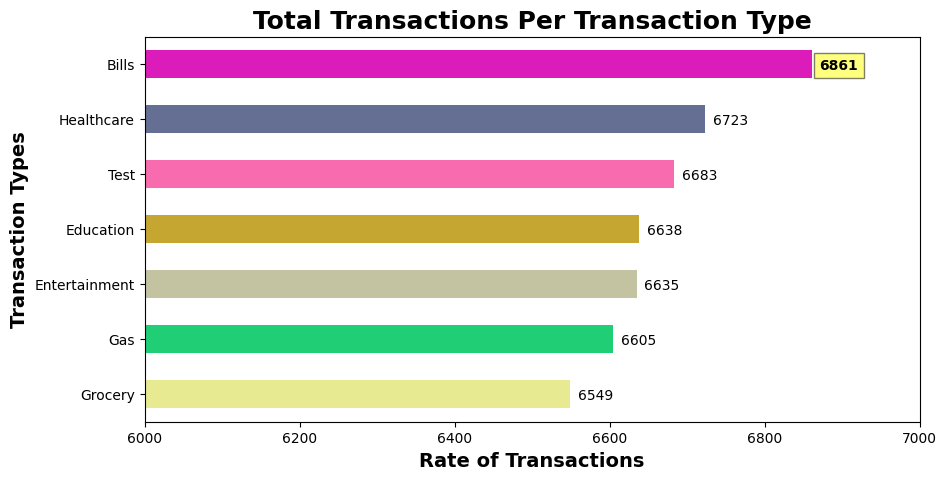

In [245]:
# Function to plot the transaction type that has high rate of transactions.
high_rate_of_tran_by_tran_type(df_tran)

## Functional Requirements 3.2

### Find and plot which state has a high number of customers.
### Note: Take a screenshot of the graphs.

### Function to find and plot which state has a high number of customers.

In [246]:
# Function to find and plot which state has a high number of customers.
def state_with_high_no_of_customers(df_cus):
    
    
    # Getting the count of customers per state.
    states = df_cus['CUST_STATE'].value_counts()


    # Set random colors for each state.
    state_color = set_colors_for_plot(len(states))

    states.sort_values(ascending=True, inplace = True)


    # Plotting the bar graph for the states.
    states.plot(kind='barh', figsize=(10, 6), color = state_color, xlim=(0,100))
 

    # Setting the title.
    plt.title('Total Number of Customers Per State', fontweight = 'bold', fontsize = '18')
    # Setting the x-label.
    plt.xlabel('Total Number of Customers', fontweight = 'bold', fontsize = '14')
    # Setting the y-label.
    plt.ylabel('State', fontweight = 'bold', fontsize = 14)


    # Displaying the number of customers for the state.
    for index, value in enumerate(states): 
      if value == states.max(axis=0):
          plt.text(value+0.6, index-0.5, str(value), bbox=dict(facecolor='yellow',alpha=0.5), fontweight = 'bold')
      else:
          plt.text(value+0.6, index-0.4, str(value))
  
    plt.show() 



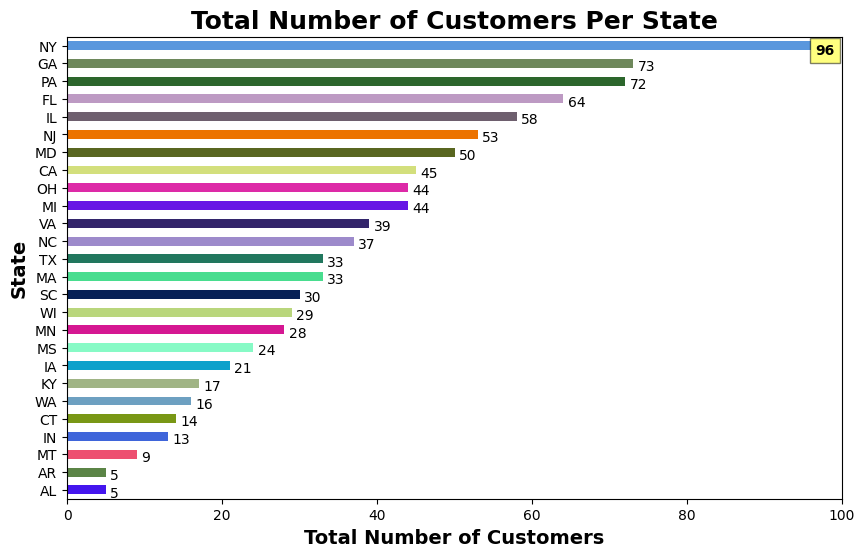

In [260]:
# Function to find and plot which state has a high number of customers.
state_with_high_no_of_customers(df_cus)

## Functional Requirements 3.3

### Find and plot the sum of all transactions for the top 10 customers,
### and which customer has the highest transaction amount.
### hint(use CUST_SSN).
### Note: Take a screenshot of the graphs.

### Function to plot the sum of all transactions for the top 10 customers,
### and which customer has the highest transaction amount.

In [261]:
# Function to plot the sum of all transactions for the top 10 customers,
# and which customer has the highest transaction amount.
# hint(use CUST_SSN).

def highest_and_sum_of_transactions_for_top10(df_customer_cc):
    

    # Getting the top 10 customers.
    top10 = df_customer_cc.groupby('CUST_SSN')['TRANSACTION_VALUE'].sum().sort_values().tail(10)
  
    # Setting the color for each customer in top 10.
    top10_colors = set_colors_for_plot(len(top10))


    # Plotting the graph for the top 10 customers having the highest total values of transactions.
    top10.plot(kind='barh', figsize=(10, 5), xlim=(4800,5800), color=top10_colors)

    
    # Setting the plot.
    plt.title('Top 10 Total Transaction Amounts Per Customer', fontweight = 'bold', fontsize = 18)
    # Setting the x-label.
    plt.xlabel('Total Transaction Amount', fontweight = 'bold', fontsize = 14)
    # Setting the y-label.
    plt.ylabel('Account Number', fontweight = 'bold', fontsize = 14)


    # Placing text i.e. sum of all transactions at the end of bar
    for index, value in enumerate(top10): 
        if value == top10.max(axis=0):
            plt.text(value+10, index-0.25, '$' +str(value), bbox=dict(facecolor='yellow',alpha=0.5), fontweight = 'bold')
        else:
            plt.text(value+10, index-0.25, '$'+str(value))
            
    
    plt.show()

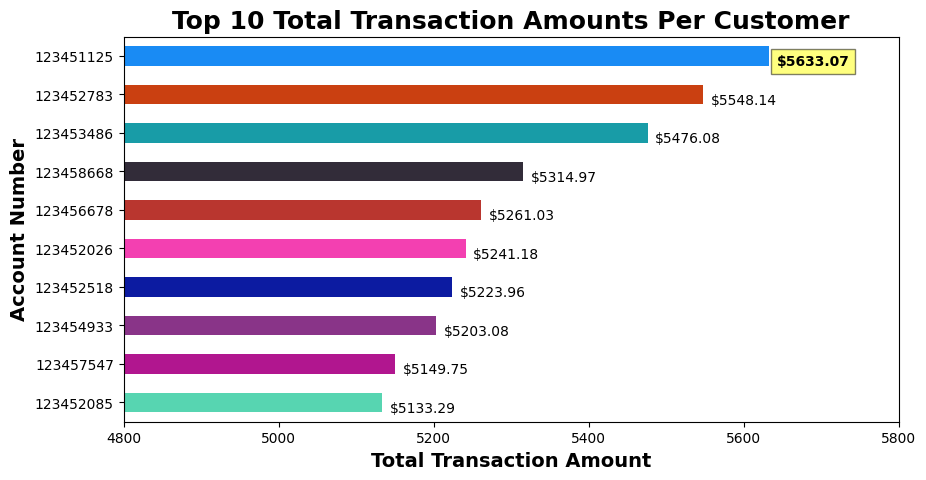

In [281]:
# Function to plot the sum of all transactions for the top 10 customers,
# and which customer has the highest transaction amount.
highest_and_sum_of_transactions_for_top10(df_customer_cc)

# LOAN application Data API

### API Endpoint: https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json

### The above URL allows you to access information about loan application information. This
### dataset has all of the required fields for a loan application. You can access data from a REST
### API by sending an HTTP request and processing the response.

## 4. Functional Requirements - LOAN Application Dataset

### Req-4 Access to Loan API Endpoint

## Functional Requirements 4.1


### Create a Python program to GET (consume) data from the above API
### endpoint for the loan application dataset.

### Function to extract the json loan data from the API response.

In [282]:
# Function to extract the json loan data from the API response.
def api_extract():

    # API url for loan application data.
    loanapi_url = 'https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json'
 
    # Getting the response from the API to get the json file.
    response = requests.get(loanapi_url)

    # Json file is loaded into the loan dataframe.
    loan_data = response.json()

    # Returns the loan data json file and the status code.
    return loan_data, response.status_code 


## Functional Requirements 4.2


### Find the status code of the above API endpoint.
### Hint: status code could be 200, 400, 404, 401.


### Function to print the API status code after reading from the response.

In [283]:
#Function to print the API status code after reading from the response.
def print_api_status_code(status):
    
    # Printing the status code.
    print('API endpoint status code: ' + str(status))

## Functional Requirements 4.3


### Once Python reads data from the API, utilize PySpark to load data into
### RDBMS(SQL). The table name should be CDW-SAPP_loan_application
### in the database.
### Note: Use the “creditcard_capstone” database.

### Function to  create a spark dataframe and load the loan data to the table CDW_SAPP_loan_application.

In [284]:
# Function to  create a spark dataframe and load the loan data to the table CDW_SAPP_loan_application.
def load_loan_data_to_database(loan_info, USER, PWD):
        
        # Creating a Spark DataFrame with the loan application data.
        df_loan_details = spark.createDataFrame(loan_info)

        # Writing the loan application data to the database table CDW_SAPP_loan_application.
        df_loan_details.write.format("jdbc") \
                        .mode("overwrite") \
                        .option("truncate", "true") \
                        .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
                        .option("dbtable", "creditcard_capstone.CDW_SAPP_loan_application") \
                        .option("user", USER) \
                        .option("password", PWD) \
                        .save()


### Function to extract and load loan data from API

In [285]:
# Function to extract and load loan API.
def loan_data_processing(USER, PWD):

    # Extracting the loan data from the API.
    loan_info, status = api_extract()

    # Displaying the status code to show whether it is successful or not.
    print_api_status_code(status)
    
    # Load the data into the database creditcard_capstone to the table CDW_SAPP_loan_application.
    load_loan_data_to_database(loan_info, USER, PWD)
    

### Fucntion to Extract and load the loan data from API only if the table CDW_SAPP_loan_application does not exists 
### in the creditcard_capstone database.

In [286]:
# Function to populate the loan application table only if the table does not exist in the 
# creditcard_capstone database.

def populate_loan_table_only_if_not_exists(USER, PWD):
    
    # Checking if the customer, branch and creditcard table exists in the creditcard_capstone database.
    # Extract and load the loan data from API only if the table CDW_SAPP_loan_application does not exists 
    # in the creditcard_capstone database.
    
    df_tab= get_records_from_database_table(USER, PWD, "information_schema.tables")
    df_tab = df_tab.filter("table_name = 'cdw_sapp_loan_application'")
       
    # Check whether any record is there in the database.
    if df_tab.isEmpty():
        try:
            loan_data_processing(USER, PWD)
        except Error as e:
            print("Error Message:", e)


In [287]:
# Function to populate the loan application table only if the table does not exist in the 
# creditcard_capstone database.
populate_loan_table_only_if_not_exists(USER,PWD)

API endpoint status code: 200


## 5 - Functional Requirements - Data Analysis and Visualization for Loan Application.


### Req-5 Data Analysis and Visualization


## Functional Requirements 5.1

### Find and plot the percentage of applications approved for self-employed applicants.

### Note: Take a screenshot of the graph.


### Function to fetch all the loan application data from the creditcard_capstone database.

In [288]:
# Function to fetch all the loan application data from the creditcard_capstone database.
def get_loan_info(USER, PWD):

    # Function to get the records from customer database table in the 
    # creditcard_capstone database.
    df_loans= get_records_from_database_table(USER, PWD, "creditcard_capstone.cdw_sapp_loan_application")
    df_loan = df_loans.toPandas()
    
    
    return df_loan

In [289]:
# Function to fetch all the loan application data from the creditcard_capstone database.
df_loan_data = get_loan_info(USER, PWD)

### Function to plot the percentage of approved applications for the self employed applicants.

In [290]:
# Function to plot the percentage of applications approved for self-employed
# applicants.

def approved_applications_for_self_employed(df_loan_data):


     # Getting the loan applicstion data for the application approved for self-employed applicants.,
     df_loan_info = df_loan_data[['Application_Status','Self_Employed']].value_counts()

     colors_list = ['yellowgreen', 'lightcoral', 'gold', 'lightblue'] 
     
        
     # Plotting the pie chart for the percentage of applications approved for self-employed applicants.
     df_loan_info.plot(kind='pie',
                             figsize=(12, 6),
                             autopct=lambda p: '{:.2f}%({:.0f})'.format(p,(p/100)*df_loan_info.sum()),
                             startangle=90,
                             labels=None,         # turn off labels on pie chart
                             pctdistance=1.28,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                             legend = True,
                             explode=(0, 0, 0.1, 0),
                             colors=colors_list
                             )


     # Scale the title up by 12% to match pctdistance
     plt.title('Percentage of Applications Approved for Self-Employed Applicants', y=1.12, fontweight = 'bold', fontsize = 15) 

     plt.axis('equal') 

     # Adding the legend
     legend_labels = ['Approved Not Self-Employed', 'Not Approved Not Self-Employed', 'Approved Self-Employed', 'Not Approved Self-Employed' ]  
     plt.legend(labels=legend_labels)

     plt.show()


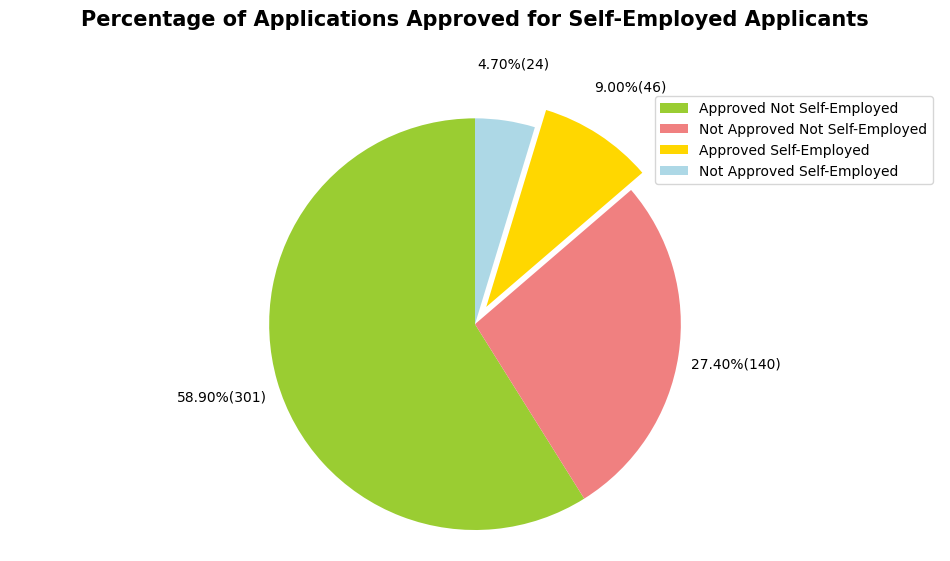

In [291]:
# Function to plot the percentage of applications approved for self-employed
# applicants.
approved_applications_for_self_employed(df_loan_data)

## Functional Requirements 5.2


### Find the percentage of rejection for married male applicants.
### Note: Take a screenshot of the graph.

### Function to plot the percentage of rejection for married male applicants.

In [292]:
# Function to find and plot the percentage of rejection for married male applicants.
def percentage_of_rejection_for_married_male(df_loan_data):

    # Getting the loan application data for the percentage of rejections for married male applicants.
    df_loan = df_loan_data[['Application_Status', 'Married', 'Gender']].value_counts()

    colors_list = ['yellowgreen', 'gold', 'lightskyblue', 'lightgreen', 'pink', 'lightblue', 'lightgrey',  'lightcoral']
    
    # Plotting  a pie chart to show the percentage of rejection for married male applicants.
    df_loan.plot(kind='pie',
                            figsize=(14, 6),
                            autopct = lambda p: '{:.2f}%({:.0f})'.format(p,(p/100)*df_loan.sum()),
                            startangle=250,
                            labels=None,         # turn off labels on pie chart
                            pctdistance=1.19,    # the ratio between the center of each pie slice and the start of the text generated by autopct
                            legend = True,
                            explode=(0, 0.1, 0, 0, 0, 0, 0, 0),
                            colors = colors_list
                           )

    # Scale the title up by 12% to match pctdistance
    plt.title('Percentage of Rejections for Married Male Applicants', 
              y=1.12, fontweight = 'bold', fontsize = 18) 

    plt.axis('equal') 

    # Adding the legend
    legend_labels = ['(Approved, Married, Male)', '(Not Approved, Married, Male)', '(Approved, Not Married, Male)', 
                     '(Not Approved, Not Married, Male)', '(Approved, Not Married, Female)', 
                     '(Not Approved, Not Mariied, Female)', '(Approved, Married, Female)', 
                     '(Not Approved, Married, Female)']
                 
    plt.legend(labels=legend_labels) 

    plt.show()


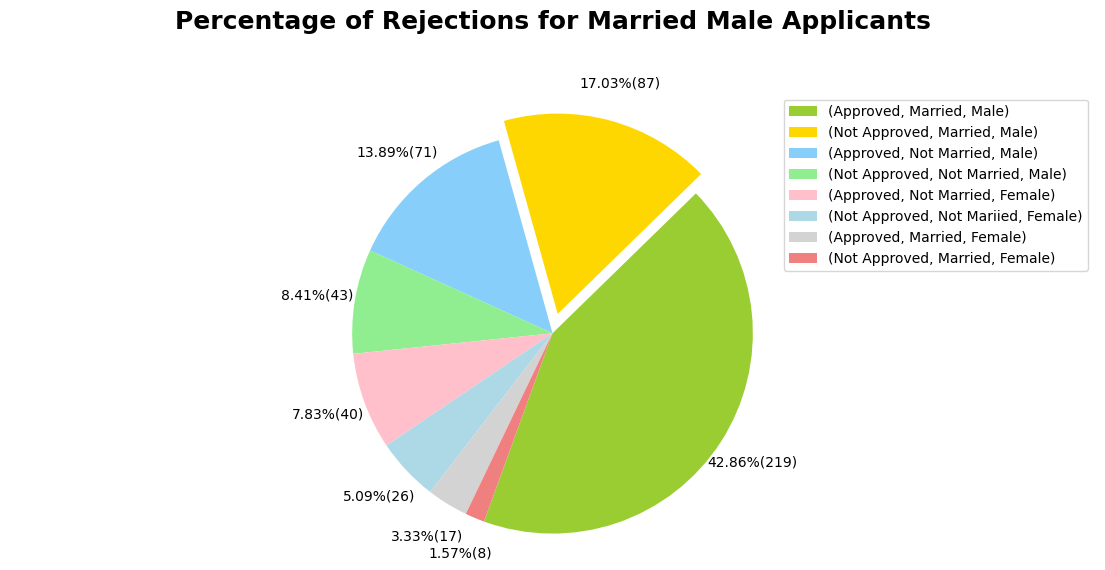

In [293]:
# Function to find and plot the percentage of rejection for married male applicants.
percentage_of_rejection_for_married_male(df_loan_data)

## Functional Requirements 5.3


### Find and plot the top three months with the largest transaction data.
### Note: Take a screenshot of the graph.


### Function to plot the top three months with the largest transaction data.

In [294]:
# Function to plot the top three months with the largest transaction data.
def top3_months_largest_transaction_data(df_tran):

    # Getting the top three months with the largest transaction data. 
    df_top3 = df_tran.loc[:, ['TIMEID', 'TRANSACTION_ID']]
    df_top3['TIMEID'] = pd.to_datetime(df_top3['TIMEID'], format='%Y%m%d').dt.month

    top_3 = df_top3['TIMEID'].value_counts().sort_values().tail(3)

    # Set the random colors for the three months.
    top3_colors = set_colors_for_plot(len(top_3))

    # Plotting the top 3 months with the largest transaction data.
    top_3.plot(kind='barh', figsize=(10, 5), xlim=(3900, 3970), color=top3_colors)
    
    
    # Setting the title.
    plt.title('Top 3 Total Number of Transactions Per Month', fontweight = 'bold', fontsize = 18)
    # Setting the x-label
    plt.xlabel('Number of Transactions', fontweight = 'bold', fontsize = 14)
    # Setting the y-label
    plt.ylabel('Month', fontweight = 'bold', fontsize = 14)


    # Getting the transaction value to be displayed near the bar of the graph
    for index, value in enumerate(top_3):
      plt.text(value+1, index-0.04, str(value), bbox=dict(facecolor='yellow',alpha=0.5), fontweight = 'bold')

  
    plt.show()

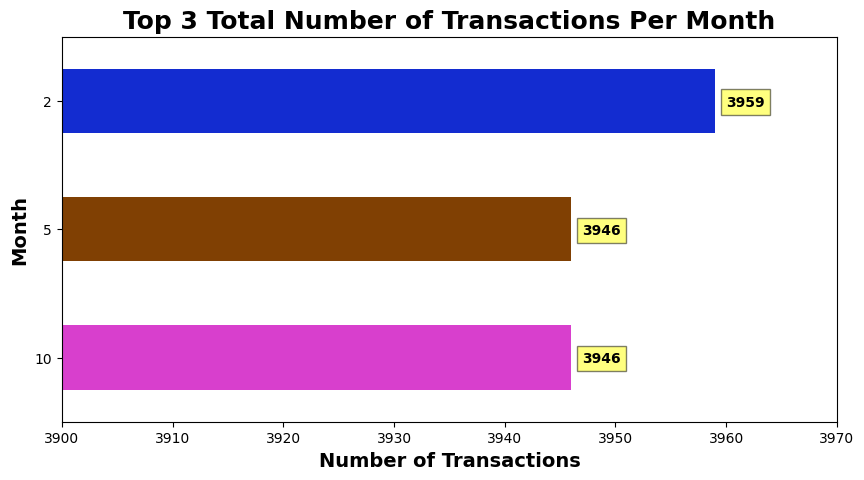

In [297]:
# Function to plot the top three months with the largest transaction data.
top3_months_largest_transaction_data(df_tran)

## Functional Requirements 5.4

### Find and plot which branch processed the highest total dollar value of healthcare transactions.
###  Note: Take a screenshot of the graph.


### Function to plot the branch that processed the highest total dollar value of healthcare transactions.

In [298]:
# Function to plot the branch that processed the highest total dollar value of
# healthcare transactions.
def branch_with_highest_total_dollar_value(df_tran):


    # Getting all the branches with the transaction data and sorting to get the highest total dollar value of healthcare transactions.
    health = df_tran[df_tran['TRANSACTION_TYPE']=='Healthcare'].groupby('BRANCH_CODE', as_index=False)['TRANSACTION_VALUE'] \
                                                                  .sum() \
                                                                  .sort_values(by='TRANSACTION_VALUE')
   
    # Set the random colors for the branches.
    branch_colors = set_colors_for_plot(len(health))

    # Plotting the scatter plot for the branches that processed transactions.
    health.plot(kind='scatter', x='BRANCH_CODE', y='TRANSACTION_VALUE',
                   figsize=(30, 10), color=branch_colors,  xlim=(0, 200))
    
    
    # Setting the title.
    plt.title('Total Dollar Value of Healthcare Transactions Per Branch', fontweight = 'bold', fontsize = 22)
    # Setting the x-label.
    plt.xlabel('Branch Number', fontweight = 'bold', fontsize = 17)
    # Setting the y-label.
    plt.ylabel('Total Value of Healthcare Transactions', fontweight = 'bold', fontsize = 17)
    

    # Displaying the branch that has the highest total with the highest total box.
    health_series = health.set_index('BRANCH_CODE').squeeze()
    for index, value in health_series.items():
        if value == health_series.max(axis=0):
            plt.text(index-5, value-120, 'Highest Total value', bbox=dict(facecolor='yellow',alpha=0.5), fontweight = 'bold')
            plt.text(index-1, value-220, '$' + str(value), bbox=dict(facecolor='yellow',alpha=0.5), fontweight = 'bold')
        plt.text(index+1, value-20, '#'+str(index))
          
    
    plt.show()

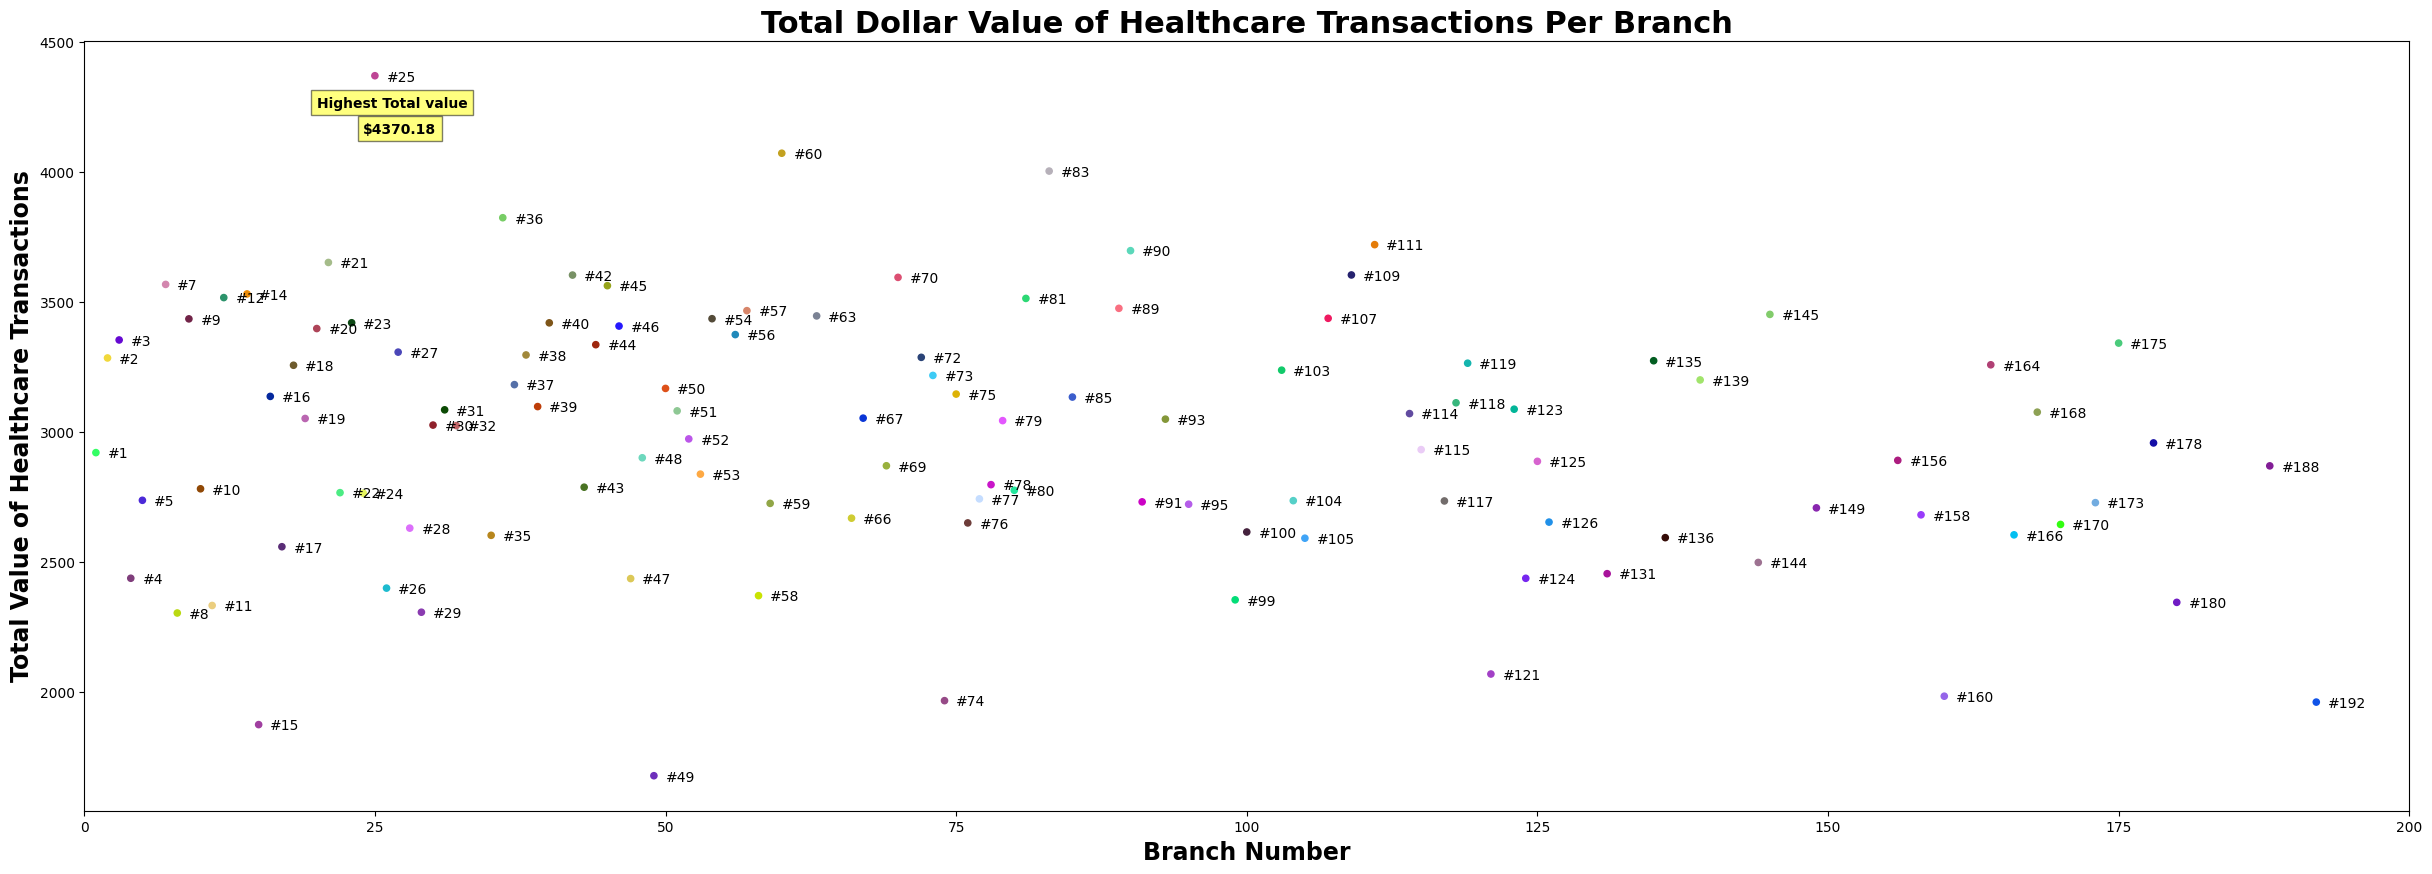

In [299]:
# Plot the branch that processed the highest total dollar value of
# healthcare transactions.
branch_with_highest_total_dollar_value(df_tran)

### Function to get the input menu.

In [300]:
# Function to get the input.
def get_input():

# Initializing the variables.

    option = ''
    run_main_menu = True
    run_t_menu = ''
    run_c_menu = ''
    run_v_menu = ''


# Populating the menu.


    main_menu = ('\n'
                 '1) Banking Transactions Menu\n'
                 '2) Customer Transaction Menu\n'
                 '3) Visualizations Menu\n'
                 '4) Quit\n')
    transaction_menu = ('\n'
                      '1) Customer Transactions by Zipcode, Month and Year\n'
                      '2) Transactions by Transaction Type\n'
                      '3) Transactions for Branches in a given State\n'
                      '4) Previous menu\n'
                      '5) Exit\n')
    customer_menu = ('\n'
                    '1) Check Existing Account Details of a Customer\n'
                    '2) Modify Existing Account Details of a Customer\n'
                    '3) Generate Monthly Credit Card Bill\n'
                    '4) List of Transaction for a Date Range\n'
                    '5) Previous menu\n'
                    '6) Exit\n')
    visualization_menu = ('\n'
                     '1) Rate of Transactions by Transaction Type\n'
                     '2) Number of Customers by State\n'
                     '3) Total Transactions for top 10 Customers\n'
                     '4) Percentage of Approved Applications for Self-Employed Applicants\n'
                     '5) Percentage of Rejection for Married Male Applicants\n'
                     '6) Top Three Months of Largest Transactions\n'
                     '7) Branch with Highest Value of Healthcare Transactions.' 
                     '8) Previous menu\n'
                     '9) Exit\n')

    return_quit_t = ('\n'
                   '1) Return to main menu\n'
                   '2) Return to transaction menu\n'
                   '3) Exit\n')
    return_quit_c = ('\n'
                   '1) Return to main menu\n'
                   '2) Return to customer menu\n'
                   '3) Exit\n')
    return_quit_v = ('\n'
                   '1) Return to main menu\n'
                   '2) Return to visualization menu\n'
                   '3) Exit\n')

   
    # Function to populate the customer, branch and creditcard tables only if it does not exist
    # in the creditcard_capstone database.
    
    populate_tables_only_if_not_exist(USER,PWD)


    # Function to populate the loan application table only if the table does not exist in the 
    # creditcard_capstone database.
    populate_loan_table_only_if_not_exists(USER,PWD)


    # Function to get all the transaction data into pandas dataframe for visualization.
    df_tran, df_cus, df_br, df_customer_cc, tran_type, branch_states, states, ssnno, cardnumbers, fstname, lstname = \
    get_data_for_transactions(USER, PWD)


    # Function to fetch all the loan application data from the creditcard_capstone database.
    df_loan_data = get_loan_info(USER, PWD)


    run_main_menu = True

    while run_main_menu:
        run_t_menu = True
        run_c_menu = True
        run_v_menu = True
        print(main_menu)
        option = input('Please enter an option: ')
        option = option.strip()

        # Transaction menu
        if option == '1':
            print(transaction_menu)
            while run_t_menu:
                    option = input('Please enter an option: ')
                    option = option.strip()

                    # Transaction details menu 1
                    if option == '1':

                        # Function to display the transactions made by customers living in a
                        # given zip code for a given month and year. Order by day in
                        # descending order.

                        transaction_customer_for_zip_month_year()

                          
                        while True:
                            print(return_quit_t)
                            option = input('Please enetr an option: ')
                            option = option.strip()
                            if option == '1':
                                run_t_menu = False
                                break
                            elif option == '2':
                                print(transaction_menu)
                                break
                            elif option == '3':
                                run_t_menu = False
                                run_main_menu = False
                                break
                            else:
                                print('\nOption {} is invalid. Try again.'.format(option))


                    # Transaction details menu 2
                    elif option == '2':

                    
                        # Function to display the number and total values of transactions for a given transaction type.
                        number_and_total_values_of_transactions(tran_type)

        
                        while True:
                            print(return_quit_t)
                            option = input('Please enter an option: ')
                            option = option.strip()
                            if option == '1':
                                run_t_menu = False
                                break
                            elif option == '2':
                                print(transaction_menu)
                                break
                            elif option == '3':
                                run_t_menu = False
                                run_main_menu = False
                                break
                            else:
                                print('\nOption {} is invalid. Try again.'.format(option))

                 
                    # Transaction details menu 3
                    elif option == '3':

                            # Function to display the number and total values of transactions for branches in a given state.
                            number_and_total_transaction_values_for_branches(branch_states)


                            while True:
                                print(return_quit_t)
                                option = input('Please enter an option: ')
                                option = option.strip()
                                if option == '1':
                                    run_t_menu = False
                                    break
                                elif option == '2':
                                    print(transaction_menu)
                                    break
                                elif option == '3':
                                    run_t_menu = False
                                    run_main_menu = False
                                    break
                                else:
                                    print('\nOption {} is invalid. Try again.'.format(option))


                    # Exit Transaction menu    
                    elif option == '4':
                        break

                    elif option == '5':
                        run_main_menu = False
                        break


                    else:
                        print('\nOption {} is invalid. Try again.'.format(option))
                        print(transaction_menu)



    # Customer menu
        elif option == '2':
            print(customer_menu)
            while run_c_menu:
                option = input('Please enter an option: ')
                option = option.strip()

                # Customer menu 1
                if option == '1':

                    # Function to check the existing account details of a customer.
                    check_customer_account_details(cardnumbers, ssnno, fstname, lstname)

                    while True:
                        print(return_quit_c)
                        option = input('Please enter an option: ')
                        option = option.strip()
                        if option == '1':
                            run_c_menu = False
                            break
                        elif option == '2':
                            print(customer_menu)
                            break
                        elif option == '3':
                            run_c_menu = False
                            run_main_menu = False
                            break
                        else:
                            print('\nOption {} is invalid. Try again.'.format(option))

            
                # Customer menu 2
                elif option == '2':

                    # Function to modify the existing account details of a customer.
                    df_customers, df_cust, df_customer_cc_info = modify_existing_account_details_of_a_customer(df_tran, ssnno, states, USER, PWD)
                    
                    while True:
                        print(return_quit_c)
                        option = input('Please enter an option: ')
                        option = option.strip()
                        if option == '1':
                            run_c_menu = False
                            break
                        elif option == '2':
                            print(customer_menu)
                            break
                        elif option == '3':
                            run_c_menu = False
                            run_main_menu = False
                            break
                        else:
                            print('\nOption {} is invalid. Try again.'.format(option))


                # Customer menu 3
                elif option == '3':

                    # Function to generate a monthly bill for a credit card number for a given month and year. 
                    credit_card_monthly_bill_for_a_month_and_year(cardnumbers)

                
                    while True:
                        print(return_quit_c)
                        option = input('Please enter an option: ')
                        option = option.strip()
                        if option == '1':
                            run_c_menu = False
                            break
                        elif option == '2':
                            print(customer_menu)
                            break
                        elif option == '3':
                            run_c_menu = False
                            run_main_menu = False
                            break
                        else:
                            print('\nOption {} is invalid. Try again.'.fornat(option))

                # Customer menu 4
                elif option == '4':
                    
                    # Display the transactions made by a customer between
                    # two dates. Order by year, month, and day in descending order.
                    transactions_by_a_customer_between_dates(cardnumbers)


                    while True:
                        print(return_quit_c)
                        option = input('Please enter an option: ')
                        option = option.strip()
                        if option == '1':
                            run_c_menu = False
                            break
                        elif option == '2':
                            print(customer_menu)
                            break
                        elif option == '3':
                            run_c_menu = False
                            run_main_menu = False
                            break
                        else:
                            print('\nOption {} is invalid. Try again.'.format(option))
                
                # Previous Menu
                elif option == '5':
                    break
                
                # Main Menu
                elif option == '6':
                    run_main_menu = False
                    break

                else:
                    print('\nOption {} is invalid. Try again.'.format(option))
                    print(customer_menu)


        # Visualization Menu     
        elif option == '3':
            print(visualization_menu)
            while run_v_menu:
                option = input('Please enter an option: ')
                option = option.strip()

                # Visulaization menu 1
                if option == '1':

                    # Function to plot the transaction type that has high rate of transactions.
                    high_rate_of_tran_by_tran_type(df_tran)
                
         
                    while True:
                        print(return_quit_v)
                        option = input('Please enter an option: ')
                        option = option.strip()
                        if option == '1':
                            run_v_menu = False
                            break
                        elif option == '2':
                            print(visualization_menu)
                            break
                        elif option == '3':
                            run_v_menu = False
                            run_main_menu = False
                            break
                        else:
                            print('\nOption {} is invalid. Try again.'.format(option))


                # Visualization menu 2
                elif option == '2':

                    # Function to find and plot which state has a high number of customers.
                    state_with_high_no_of_customers(df_cus)

   
                    while True:
                        print(return_quit_v)
                        option = input('Please enter an option: ')
                        option = option.strip()
                        if option == '1':
                            run_v_menu = False
                            break
                        elif option == '2':
                            print(visualization_menu)
                            break
                        elif option == '3':
                            run_v_menu = False
                            run_main_menu = False
                            break
                        else:
                            print('\nOption {} is invalid. Try again.'.format(option))

                
                # Visualization menu 3
                elif option == '3':

                    # Function to plot the sum of all transactions for the top 10 customers,
                    # and which customer has the highest transaction amount.
                    highest_and_sum_of_transactions_for_top10(df_customer_cc)

           
                    while True:
                        print(return_quit_v)
                        option = input('Please enter an option: ')
                        option = option.strip()
                        if option == '1':
                            run_v_menu = False
                            break
                        elif option == '2':
                            print(visualization_menu)
                            break
                        elif option == '3':
                            run_v_menu = False
                            run_main_menu = False
                            break
                        else:
                            print('\nOption {} is invalid. Try again.'.format(option))


                # Visualization menu 4
                elif option == '4':

                    # Function to plot the percentage of applications approved for self-employed
                    # applicants.
                    approved_applications_for_self_employed(df_loan_data)

    
                    while True:
                        print(return_quit_v)
                        option = input('Please enter an option: ')
                        option = option.strip()
                        if option == '1':
                            run_v_menu = False
                            break
                        elif option == '2':
                            print(visualization_menu)
                            break
                        elif option == '3':
                            run_v_menu = False
                            run_main_menu = False
                            break
                        else:
                            print('\nOption {} is invalid. Try again.'.format(option))


                # Visualization menu 5
                elif option == '5':

                    # Function to find and plot the percentage of rejection for married male applicants.
                    percentage_of_rejection_for_married_male(df_loan_data)

          
                    while True:
                        print(return_quit_v)
                        option = input('Please enter an option: ')
                        option = option.strip()
                        if option == '1':
                            run_v_menu = False
                            break
                        elif option == '2':
                            print(visualization_menu)
                            break
                        elif option == '3':
                            run_v_menu = False
                            run_main_menu = False
                            break
                        else:
                            print('\nOption {} is invalid. Try again.'.format(option))


                # Visualization menu 6
                elif option == '6':

                    # Function to plot the top three months with the largest transaction data.
                    top3_months_largest_transaction_data(df_tran)
                
         
                    while True:
                        print(return_quit_v)
                        option = input('Please enter an option: ')
                        option = option.strip()
                        if option == '1':
                            run_v_menu = False
                            break
                        elif option == '2':
                            print(visualization_menu)
                            break
                        elif option == '3':
                            run_v_menu = False
                            run_main_menu = False
                            break
                        else:
                            print('\nOption is invalid. Try again.'.format(option))


                # Visulaization menu 7
                elif option == '7':

                    # Plot the branch that processed the highest total dollar value of
                    # healthcare transactions.
                    branch_with_highest_total_dollar_value(df_tran)

      
                    while True:
                        print(return_quit_v)
                        option = input('Please enter an option: ')
                        option = option.strip()
                        if option == '1':
                            run_v_menu = False
                            break
                        elif option == '2':
                            print(visualization_menu)
                            break
                        elif option == '3':
                            run_v_menu = False
                            run_main_menu = False
                            break
                        else:
                            print('\nOption {} is invalid. Try again.'.format(option))

               
                # Previous menu
                elif option == '8':
                    break
                
                # Main menu
                elif option == '9':

                    run_main_menu = False
                    break

                else:
                    print('\nOption {} is invalid. Try again.'.format(option))
                    print(visualization_menu)

    
        # Exit menu
        elif option == '4':
            break
    
        else:
            print('\nOption {} is invalid. Try again.'.format(option))

    
    # Stop the spark session.
    spark.stop()



### Function call to get the input.

In [57]:
get_input()

### Stopping the Spark Session.

In [176]:
spark.stop()